# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
####################data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

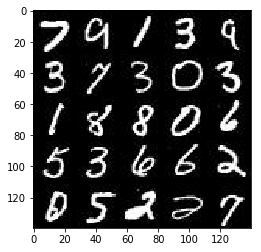

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

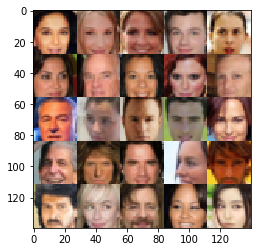

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, lr 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [43]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse) :
        # Input layer is 28 X 28 X 3 [32x32x3]
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        x1 = tf.maximum(alpha * x1, x1)
        # 14 X 14 X 64 [16x16x64]
        
        x1 = tf.nn.dropout(x1, 0.5)
        print("X1:", x1.get_shape())
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7 X 7 X 128 [8x8x128]
        
        x2 = tf.nn.dropout(x2, 0.5)
        print("X2:", x2.get_shape())
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4x4x256
        
        x3 = tf.nn.dropout(x3, 0.5)
        print("X3:", x3.get_shape())

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        #print("OUT SHAPE", tf.shape(out))
        print("OUT:", out.get_shape())
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

X1: (?, 14, 14, 64)
X2: (?, 7, 7, 128)
X3: (?, 4, 4, 256)
OUT: (?, 1)
X1: (?, 14, 14, 64)
X2: (?, 7, 7, 128)
X3: (?, 4, 4, 256)
OUT: (?, 1)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [44]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    print(tf.shape(z))
    print("INPUT Z", z.get_shape())
    
    #alpha = 0.01
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train) as scope:
        # Fully connected
        fc1 = tf.layers.dense(z, 7*7*256)
        #fc1 = tf.layers.dense(z, 4*4*256)

        # Reshape
        x1 = tf.reshape(fc1, (-1, 7, 7, 256))
        #x1 = tf.reshape(fc1, (-1, 4, 4, 256))
        
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.nn.relu(x1)
        
        x1 = tf.nn.dropout(x1, 0.5)
        print("X1:", x1.get_shape())

        # Second layer 
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        
        x2 = tf.nn.dropout(x2, 0.5)
        print("X2:", x2.get_shape())

        # Ouput layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='SAME')
        out = tf.tanh(logits)
        # (28 x 28 x out_channel_dim)
        
        #print("OUT SHAPE", tf.shape(out))
        print("OUT:", out.get_shape())

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tensor("Shape:0", shape=(2,), dtype=int32)
INPUT Z (?, 100)
X1: (?, 7, 7, 256)
X2: (?, 14, 14, 128)
OUT: (?, 28, 28, 5)
Tensor("Shape_1:0", shape=(2,), dtype=int32)
INPUT Z (?, 100)
X1: (?, 7, 7, 256)
X2: (?, 14, 14, 128)
OUT: (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [50]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
            
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
   
    #smooth = 0
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1-smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("Shape:0", shape=(2,), dtype=int32)
INPUT Z (?, 100)
X1: (?, 7, 7, 256)
X2: (?, 14, 14, 128)
OUT: (?, 28, 28, 4)
X1: (?, 14, 14, 64)
X2: (?, 7, 7, 128)
X3: (?, 4, 4, 256)
OUT: (?, 1)
X1: (?, 14, 14, 64)
X2: (?, 7, 7, 128)
X3: (?, 4, 4, 256)
OUT: (?, 1)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [46]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #print(d_loss)
    #print(g_loss)
    #print(learning_rate)
    #print(beta1)
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
    #    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    #    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            print("Epoch {}/{}....".format(epoch_i+1, epoch_count))
            batch_i = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                print("Batch {}/{}....".format(batch_i+1, batch_size))
                batch_i += 1
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # the values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.
                # Thus, need to rescale the images to be between -1 and 1 as using tanh in generator function to get logits
                batch_images = batch_images * 2
                
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})

            train_loss_d = sess.run(d_loss, {input_z:batch_z, input_real:batch_images})
            train_loss_g = g_loss.eval({input_z:batch_z})
            print("Epoch {}/{}....".format(epoch_i+1, epoch_count), 
                 "Discriminator Loss: {:.4f}....".format(train_loss_d),
                 "Generator Loss: {:.4f}....".format(train_loss_g))
            show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
            
            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Tensor("Shape:0", shape=(2,), dtype=int32)
INPUT Z (?, 100)
X1: (?, 7, 7, 256)
X2: (?, 14, 14, 128)
OUT: (?, 28, 28, 1)
X1: (?, 14, 14, 64)
X2: (?, 7, 7, 128)
X3: (?, 4, 4, 256)
OUT: (?, 1)
X1: (?, 14, 14, 64)
X2: (?, 7, 7, 128)
X3: (?, 4, 4, 256)
OUT: (?, 1)
Epoch 1/2....
Batch 1/128....
Batch 2/128....
Batch 3/128....
Batch 4/128....
Batch 5/128....
Batch 6/128....
Batch 7/128....
Batch 8/128....
Batch 9/128....
Batch 10/128....
Batch 11/128....
Batch 12/128....
Batch 13/128....
Batch 14/128....
Batch 15/128....
Batch 16/128....
Batch 17/128....
Batch 18/128....
Batch 19/128....
Batch 20/128....
Batch 21/128....
Batch 22/128....
Batch 23/128....
Batch 24/128....
Batch 25/128....
Batch 26/128....
Batch 27/128....
Batch 28/128....
Batch 29/128....
Batch 30/128....
Batch 31/128....
Batch 32/128....
Batch 33/128....
Batch 34/128....
Batch 35/128....
Batch 36/128....
Batch 37/128....
Batch 38/128....
Batch 39/128....
Batch 40/128....
Batch 41/128....
Batch 42/128....
Batch 43/128....
Batc

Batch 447/128....
Batch 448/128....
Batch 449/128....
Batch 450/128....
Batch 451/128....
Batch 452/128....
Batch 453/128....
Batch 454/128....
Batch 455/128....
Batch 456/128....
Batch 457/128....
Batch 458/128....
Batch 459/128....
Batch 460/128....
Batch 461/128....
Batch 462/128....
Batch 463/128....
Batch 464/128....
Batch 465/128....
Batch 466/128....
Batch 467/128....
Batch 468/128....
Epoch 1/2.... Discriminator Loss: 0.9981.... Generator Loss: 1.9285....
Tensor("Shape_1:0", shape=(2,), dtype=int32)
INPUT Z (?, 100)
X1: (?, 7, 7, 256)
X2: (?, 14, 14, 128)
OUT: (?, 28, 28, 1)


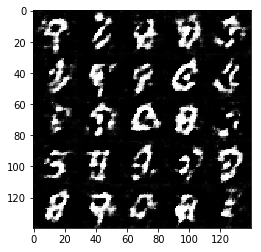

Epoch 2/2....
Batch 1/128....
Batch 2/128....
Batch 3/128....
Batch 4/128....
Batch 5/128....
Batch 6/128....
Batch 7/128....
Batch 8/128....
Batch 9/128....
Batch 10/128....
Batch 11/128....
Batch 12/128....
Batch 13/128....
Batch 14/128....
Batch 15/128....
Batch 16/128....
Batch 17/128....
Batch 18/128....
Batch 19/128....
Batch 20/128....
Batch 21/128....
Batch 22/128....
Batch 23/128....
Batch 24/128....
Batch 25/128....
Batch 26/128....
Batch 27/128....
Batch 28/128....
Batch 29/128....
Batch 30/128....
Batch 31/128....
Batch 32/128....
Batch 33/128....
Batch 34/128....
Batch 35/128....
Batch 36/128....
Batch 37/128....
Batch 38/128....
Batch 39/128....
Batch 40/128....
Batch 41/128....
Batch 42/128....
Batch 43/128....
Batch 44/128....
Batch 45/128....
Batch 46/128....
Batch 47/128....
Batch 48/128....
Batch 49/128....
Batch 50/128....
Batch 51/128....
Batch 52/128....
Batch 53/128....
Batch 54/128....
Batch 55/128....
Batch 56/128....
Batch 57/128....
Batch 58/128....
Batch 59/

Batch 462/128....
Batch 463/128....
Batch 464/128....
Batch 465/128....
Batch 466/128....
Batch 467/128....
Batch 468/128....
Epoch 2/2.... Discriminator Loss: 0.8601.... Generator Loss: 2.1258....
Tensor("Shape_2:0", shape=(2,), dtype=int32)
INPUT Z (?, 100)
X1: (?, 7, 7, 256)
X2: (?, 14, 14, 128)
OUT: (?, 28, 28, 1)


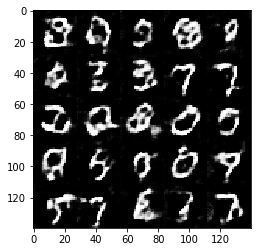

In [49]:
batch_size = 128 #512 # 128 #None
z_dim = 100 #32 #None
learning_rate = 0.0002 #0.002 # 0.01 #None
beta1 = 0.5 #0.1 #None

"""
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5
"""


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Tensor("Shape:0", shape=(2,), dtype=int32)
INPUT Z (?, 100)
X1: (?, 7, 7, 256)
X2: (?, 14, 14, 128)
OUT: (?, 28, 28, 3)
X1: (?, 14, 14, 64)
X2: (?, 7, 7, 128)
X3: (?, 4, 4, 256)
OUT: (?, 1)
X1: (?, 14, 14, 64)
X2: (?, 7, 7, 128)
X3: (?, 4, 4, 256)
OUT: (?, 1)
Epoch 1/1....
Batch 1/128....
Batch 2/128....
Batch 3/128....
Batch 4/128....
Batch 5/128....
Batch 6/128....
Batch 7/128....
Batch 8/128....
Batch 9/128....
Batch 10/128....
Batch 11/128....
Batch 12/128....
Batch 13/128....
Batch 14/128....
Batch 15/128....
Batch 16/128....
Batch 17/128....
Batch 18/128....
Batch 19/128....
Batch 20/128....
Batch 21/128....
Batch 22/128....
Batch 23/128....
Batch 24/128....
Batch 25/128....
Batch 26/128....
Batch 27/128....
Batch 28/128....
Batch 29/128....
Batch 30/128....
Batch 31/128....
Batch 32/128....
Batch 33/128....
Batch 34/128....
Batch 35/128....
Batch 36/128....
Batch 37/128....
Batch 38/128....
Batch 39/128....
Batch 40/128....
Batch 41/128....
Batch 42/128....
Batch 43/128....
Batc

Batch 447/128....
Batch 448/128....
Batch 449/128....
Batch 450/128....
Batch 451/128....
Batch 452/128....
Batch 453/128....
Batch 454/128....
Batch 455/128....
Batch 456/128....
Batch 457/128....
Batch 458/128....
Batch 459/128....
Batch 460/128....
Batch 461/128....
Batch 462/128....
Batch 463/128....
Batch 464/128....
Batch 465/128....
Batch 466/128....
Batch 467/128....
Batch 468/128....
Batch 469/128....
Batch 470/128....
Batch 471/128....
Batch 472/128....
Batch 473/128....
Batch 474/128....
Batch 475/128....
Batch 476/128....
Batch 477/128....
Batch 478/128....
Batch 479/128....
Batch 480/128....
Batch 481/128....
Batch 482/128....
Batch 483/128....
Batch 484/128....
Batch 485/128....
Batch 486/128....
Batch 487/128....
Batch 488/128....
Batch 489/128....
Batch 490/128....
Batch 491/128....
Batch 492/128....
Batch 493/128....
Batch 494/128....
Batch 495/128....
Batch 496/128....
Batch 497/128....
Batch 498/128....
Batch 499/128....
Batch 500/128....
Batch 501/128....
Batch 502/

Batch 903/128....
Batch 904/128....
Batch 905/128....
Batch 906/128....
Batch 907/128....
Batch 908/128....
Batch 909/128....
Batch 910/128....
Batch 911/128....
Batch 912/128....
Batch 913/128....
Batch 914/128....
Batch 915/128....
Batch 916/128....
Batch 917/128....
Batch 918/128....
Batch 919/128....
Batch 920/128....
Batch 921/128....
Batch 922/128....
Batch 923/128....
Batch 924/128....
Batch 925/128....
Batch 926/128....
Batch 927/128....
Batch 928/128....
Batch 929/128....
Batch 930/128....
Batch 931/128....
Batch 932/128....
Batch 933/128....
Batch 934/128....
Batch 935/128....
Batch 936/128....
Batch 937/128....
Batch 938/128....
Batch 939/128....
Batch 940/128....
Batch 941/128....
Batch 942/128....
Batch 943/128....
Batch 944/128....
Batch 945/128....
Batch 946/128....
Batch 947/128....
Batch 948/128....
Batch 949/128....
Batch 950/128....
Batch 951/128....
Batch 952/128....
Batch 953/128....
Batch 954/128....
Batch 955/128....
Batch 956/128....
Batch 957/128....
Batch 958/

Batch 1340/128....
Batch 1341/128....
Batch 1342/128....
Batch 1343/128....
Batch 1344/128....
Batch 1345/128....
Batch 1346/128....
Batch 1347/128....
Batch 1348/128....
Batch 1349/128....
Batch 1350/128....
Batch 1351/128....
Batch 1352/128....
Batch 1353/128....
Batch 1354/128....
Batch 1355/128....
Batch 1356/128....
Batch 1357/128....
Batch 1358/128....
Batch 1359/128....
Batch 1360/128....
Batch 1361/128....
Batch 1362/128....
Batch 1363/128....
Batch 1364/128....
Batch 1365/128....
Batch 1366/128....
Batch 1367/128....
Batch 1368/128....
Batch 1369/128....
Batch 1370/128....
Batch 1371/128....
Batch 1372/128....
Batch 1373/128....
Batch 1374/128....
Batch 1375/128....
Batch 1376/128....
Batch 1377/128....
Batch 1378/128....
Batch 1379/128....
Batch 1380/128....
Batch 1381/128....
Batch 1382/128....
Batch 1383/128....
Batch 1384/128....
Batch 1385/128....
Batch 1386/128....
Batch 1387/128....
Batch 1388/128....
Batch 1389/128....
Batch 1390/128....
Batch 1391/128....
Batch 1392/1

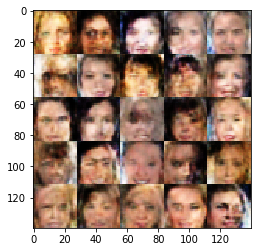

In [51]:
batch_size = 128 #512 #32 #None
z_dim = 100 #32 #100 #32 #None
learning_rate = 0.0002 # 0.01 #None
beta1 = 0.5 #0.1 #0.5 #0.1 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.